In [113]:
from jedi.api.refactoring import inline

# -*- coding: utf-8 -*-
"""
Created on Wed Oct 29 15:40:04 2025

@author: zemsk


Bleaching Presence Detection

Goal: Classify whether bleaching occurred or not.
Target variable: Binary version of Percent_Bleaching

Not bleaching: [0% - 0.5%]
Bleaching: (0.5% - 100%]



"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os


path = "./coral-reef-global-bleaching"
filename_read = os.path.join(path, "coral_whole.csv")

df = pd.read_csv(filename_read)

df["Percent_Bleaching"] = pd.to_numeric(df["Percent_Bleaching"], errors="coerce")
df = df.dropna()

df["Bleaching_Binary"] = (df["Percent_Bleaching"] > 0.5).astype(int)

df.info()




<class 'pandas.core.frame.DataFrame'>
Index: 22561 entries, 6981 to 35042
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sample_ID            22561 non-null  int64  
 1   Cyclone_Frequency    22561 non-null  float64
 2   Depth_m              22561 non-null  float64
 3   ClimSST              22561 non-null  float64
 4   Ocean_Name           22561 non-null  object 
 5   Country_Name         22561 non-null  object 
 6   Distance_to_Shore    22561 non-null  float64
 7   Exposure             22561 non-null  object 
 8   Turbidity            22561 non-null  float64
 9   Date_Year            22561 non-null  int64  
 10  Bleaching_Level      22561 non-null  object 
 11  Temperature_Maximum  22561 non-null  float64
 12  SSTA                 22561 non-null  float64
 13  TSA                  22561 non-null  float64
 14  Percent_Bleaching    22561 non-null  float64
 15  Temperature_Mean     22561 non-null  f

In [114]:
from sklearn.preprocessing import LabelEncoder

df.drop("Ocean_Name", axis=1, inplace=True)
df.drop("Country_Name", axis=1, inplace=True)
df.drop("Sample_ID", axis=1, inplace=True)
df.drop("Date_Year", axis=1, inplace=True)

le = LabelEncoder()
df["Exposure"] = le.fit_transform(df["Exposure"])
df["Bleaching_Level"] = le.fit_transform(df["Bleaching_Level"])
df["Realm_Name"] = le.fit_transform(df["Realm_Name"])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22561 entries, 6981 to 35042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cyclone_Frequency    22561 non-null  float64
 1   Depth_m              22561 non-null  float64
 2   ClimSST              22561 non-null  float64
 3   Distance_to_Shore    22561 non-null  float64
 4   Exposure             22561 non-null  int64  
 5   Turbidity            22561 non-null  float64
 6   Bleaching_Level      22561 non-null  int64  
 7   Temperature_Maximum  22561 non-null  float64
 8   SSTA                 22561 non-null  float64
 9   TSA                  22561 non-null  float64
 10  Percent_Bleaching    22561 non-null  float64
 11  Temperature_Mean     22561 non-null  float64
 12  Realm_Name           22561 non-null  int64  
 13  Percent_Cover        22561 non-null  float64
 14  Bleaching_Binary     22561 non-null  int64  
dtypes: float64(11), int64(4)
memory usage:

<Figure size 1000x500 with 0 Axes>

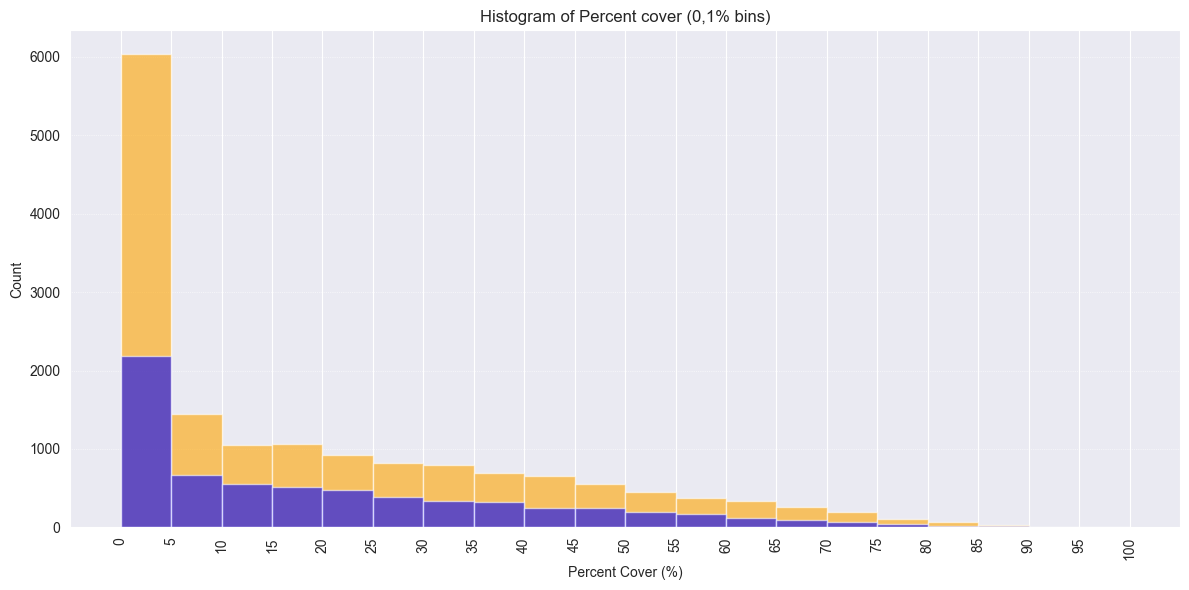

In [115]:

high_bleaching = df["Percent_Bleaching"] >= 0.5  # 50% threshold
low_bleaching = df["Percent_Bleaching"] < 0.5

bins = np.arange(0, 105, 5)  # from 0 to 100 in steps of 0.5
labels = [f"{b}–{b+5}%" for b in bins[:-1]]


plt.figure(figsize=(10, 5))
plt.figure(figsize=(12, 6))
plt.hist(
    df.loc[low_bleaching, "Percent_Cover"],
    bins=bins,
    color="orange",
    alpha=0.6,
    edgecolor=None,
    label="Low / Not Bleaching (≤0.5%)"
)
plt.hist(
    df.loc[high_bleaching, "Percent_Cover"],
    bins=bins,
    color="blue",
    alpha=0.6,
    edgecolor=None,
    label="Bleaching (>0.5%)"
)
plt.xticks(bins)
plt.xlabel("Percent Cover (%)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Histogram of Percent cover (0,1% bins)")
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()



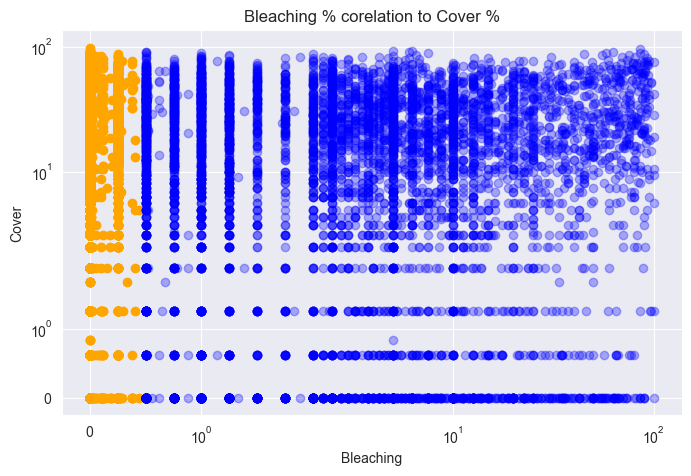

In [116]:
"""
Plot data to see corelation between Percent Bleaching and Percent Cover
"""    
plt.figure(figsize=(8, 5))

plt.scatter(
    (df.loc[low_bleaching, "Percent_Bleaching"]),
    (df.loc[low_bleaching, "Percent_Cover"]),
    color="orange")

plt.scatter(
            (df.loc[high_bleaching, "Percent_Bleaching"]),
            (df.loc[high_bleaching, "Percent_Cover"]),
            color="Blue", alpha=0.3)      
   

plt.title("Bleaching % corelation to Cover %")
plt.xlabel("Bleaching")
plt.ylabel("Cover")

plt.xscale("symlog")
plt.yscale("symlog")

plt.show()


In [117]:
print(len(low_bleaching[high_bleaching[:] == 1]) / len(low_bleaching[low_bleaching[:] == 1]))

"""
See total distribution of classes

Bleaching:	6,015	26.66%
Not bleaching:	16,546	73.34%

Most of corals werent bleached
0.42053897494018383
low bleaching/ High bleaching
after droping all na rows


most of data is distributed around 0
"""


0.42053897494018383


'\nSee total distribution of classes\n\nBleaching:\t6,015\t26.66%\nNot bleaching:\t16,546\t73.34%\n\nMost of corals werent bleached\n0.42053897494018383\nlow bleaching/ High bleaching\nafter droping all na rows\n\n\nmost of data is distributed around 0\n'

In [118]:

corr_matrix = df.corr()

features = corr_matrix.index
features

Index(['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore',
       'Exposure', 'Turbidity', 'Bleaching_Level', 'Temperature_Maximum',
       'SSTA', 'TSA', 'Percent_Bleaching', 'Temperature_Mean', 'Realm_Name',
       'Percent_Cover', 'Bleaching_Binary'],
      dtype='object')

<Axes: >

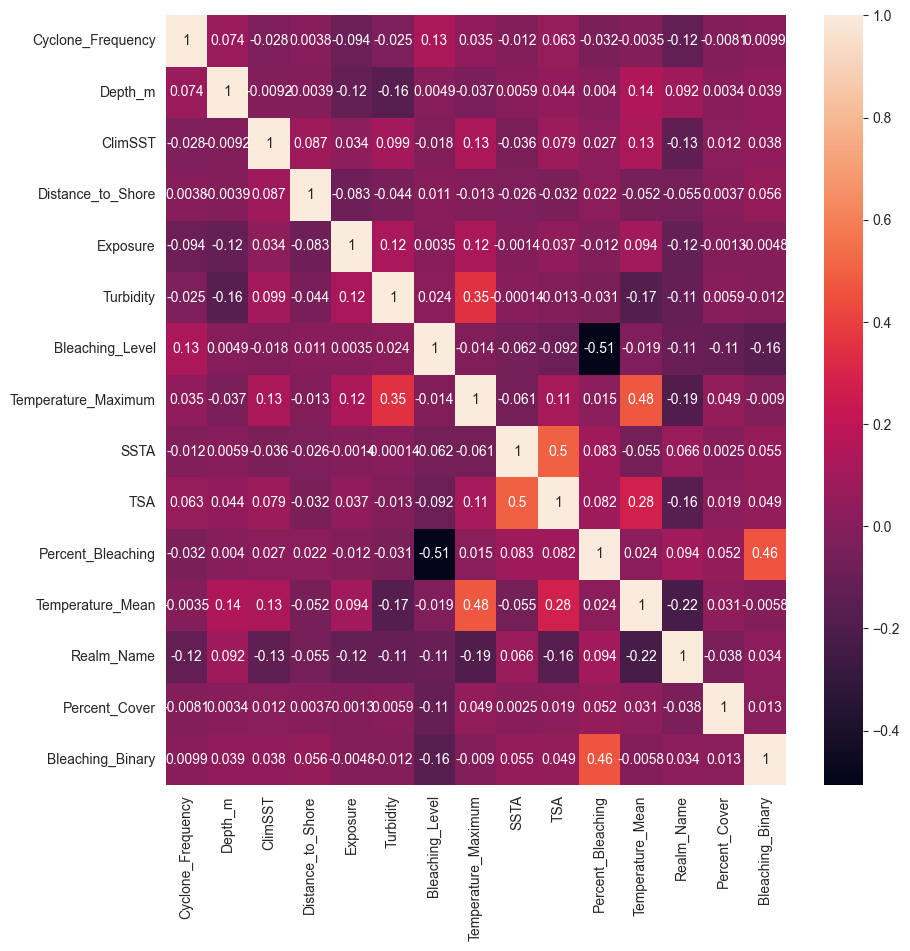

In [119]:
import seaborn as sns


plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

TSA feature highly dependent on SSTA and have high correlation rate.
 It means we can drop it for better prediction

Definition:
weeks SST TSA
Thermal Stress Anomaly: Weekly sea surface temperature minus the maximum of weekly
climatological sea surface temperature

Exposure not a good predictor
Also Temperature mean and max are highly dependent, but mean is a better predictor so max gonna be dropped

Bleaching doesnt rely on Bleaching level(


In [120]:
df.drop("SSTA", axis=1, inplace=True)
df.drop("Percent_Bleaching", axis=1, inplace=True)
df.drop("Exposure", axis=1, inplace=True)
df.drop("Temperature_Maximum", axis=1, inplace=True)
df.drop("Bleaching_Level", axis=1, inplace=True)
df.drop("Realm_Name", axis=1, inplace=True)

In [121]:

from sklearn.ensemble import ExtraTreesClassifier

tree_classifier = ExtraTreesClassifier()

y = df["Bleaching_Binary"]
x = df.drop("Bleaching_Binary", axis=1)



In [122]:
tree_classifier.fit(x, y)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [123]:
col = ['Cyclone_Frequency', 'Depth_m', 'ClimSST', 'Distance_to_Shore',
       'Turbidity', 'TSA', 'Temperature_Mean', 'Percent_Cover']

<Axes: >

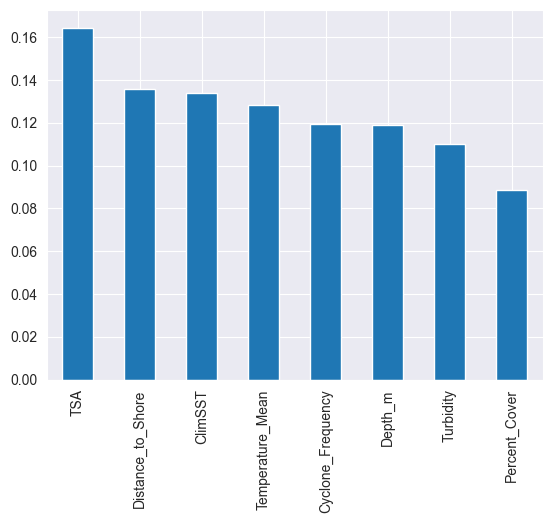

In [124]:
imp = pd.Series(tree_classifier.feature_importances_, index=col)
imp.nlargest(20).plot(kind='bar')

Out of this histogram it can be inferred that all sort of temperature parameters are the best predictors of coral bleaching